# Example: Reachability problem solved by [Hierarchical abstraction](https://github.com/dionysos-dev/Dionysos.jl/blob/master/docs/src/manual/manual.md#solvers).

In [1]:
using StaticArrays, JuMP, Plots
using MathematicalSystems
MS = MathematicalSystems

MathematicalSystems

At this point, we import Dionysos.

In [2]:
using Dionysos
const DI = Dionysos
const UT = DI.Utils
const DO = DI.Domain
const ST = DI.System
const SY = DI.Symbolic
const PR = DI.Problem
const OP = DI.Optim
const AB = OP.Abstraction

rectX = UT.HyperRectangle(SVector(0.0, 0.0), SVector(60.0, 60.0))
obsX = UT.LazyUnionSetArray([UT.HyperRectangle(SVector(22.0, 21.0), SVector(25.0, 32.0))])
_X_ = UT.LazySetMinus(rectX, obsX)

rectU = UT.HyperRectangle(SVector(-2.0, -2.0), SVector(2.0, 2.0))
obsU = UT.LazyUnionSetArray([UT.HyperRectangle(SVector(-0.5, -0.5), SVector(0.5, 0.5))])
_U_ = UT.LazySetMinus(rectU, obsU)

dt = 0.8
fd = (x, u) -> x + dt*u
concrete_system = MS.ConstrainedBlackBoxControlDiscreteSystem(fd, 2, 2, _X_, _U_)

_I_ = UT.HyperRectangle(SVector(6.5, 6.5), SVector(7.5, 7.5))
_T_ = UT.HyperRectangle(SVector(44.0, 43.0), SVector(49.0, 48.0))
concrete_problem = PR.OptimalControlProblem(
    concrete_system,
    _I_,
    _T_,
    UT.ZeroFunction(),
    UT.ConstantControlFunction(1.0),
    PR.Infinity(),
)

# specific functions
function post_image(abstract_system, concrete_system, xpos, u)
    f = MS.mapping(concrete_system)   # (x,u) -> xnext

    Xdom = abstract_system.Xdom
    x = DO.get_coord_by_pos(Xdom, xpos)
    Fx = f(x, u)
    r = DO.get_grid(Xdom).h / 2.0
    Fr = r

    rectI = DO.get_pos_lims_outer(DO.get_grid(Xdom), UT.HyperRectangle(Fx .- Fr, Fx .+ Fr))
    ypos_iter = Iterators.product(DO._ranges(rectI)...)
    over_approx = []
    allin = true
    for ypos in ypos_iter
        if !(ypos in abstract_system)
            allin = false
            break
        end
        target = SY.get_state_by_xpos(abstract_system, ypos)[1]
        push!(over_approx, target)
    end
    return allin ? over_approx : []
end

# specific functions
backward_map = (x, u) -> x - dt*u
function pre_image(abstract_system, xpos, u)
    Xdom = abstract_system.Xdom
    x = DO.get_coord_by_pos(Xdom, xpos)

    potential = Int[]
    x_prev = backward_map(x, u)
    xpos_cell = DO.get_pos_by_coord(Xdom, x_prev)

    n = 2
    for i in (-n):n, j in (-n):n
        x_n = (xpos_cell[1] + i, xpos_cell[2] + j)
        if x_n in abstract_system
            cell = SY.get_state_by_xpos(abstract_system, x_n)[1]
            if !(cell in potential)
                push!(potential, cell)
            end
        end
    end
    return potential
end

function compute_reachable_set(rect::UT.HyperRectangle, concrete_system, Udom)
    f = MS.mapping(concrete_system)   # (x,u) -> xnext

    r = (rect.ub - rect.lb) / 2.0
    Fr = r
    x = UT.get_center(rect)
    n = UT.get_dims(rect)

    lb = fill(Inf, n)
    ub = fill(-Inf, n)

    for u in DO.enum_elems(Udom)
        Fx = f(x, u)
        lb = min.(lb, Fx .- Fr)
        ub = max.(ub, Fx .+ Fr)
    end
    return UT.HyperRectangle(SVector{n}(lb), SVector{n}(ub))
end

minimum_transition_cost(symmodel, contsys, source, target) = 1.0

concrete_system = concrete_problem.system;

Local optimizer parameters

In [3]:
hx_local = SVector(0.5, 0.5)
hx_heuristic = SVector(1.0, 1.0)
u0 = SVector(0.0, 0.0)
hu = SVector(0.5, 0.5)
Ugrid = DO.GridFree(u0, hu)

local_optimizer = MOI.instantiate(AB.LazyAbstraction.Optimizer)

AB.LazyAbstraction.set_optimizer_parameters!(
    local_optimizer,
    100,
    pre_image,
    post_image,
    compute_reachable_set,
    minimum_transition_cost,
    hx_local,
    hx_heuristic;
    γ = 10.0,
)

Global optimizer parameters

In [4]:
hx_global = SVector(10.0, 10.0)
u0 = SVector(0.0, 0.0)
hu = SVector(0.5, 0.5)
Ugrid = DO.GridFree(u0, hu)
max_iter = 6
max_time = 1000

periodic_dims = SVector{0, Int}()
periodic_periods = SVector{0, Float64}()
periodic_start = SVector{0, Float64}()

optimizer = MOI.instantiate(AB.HierarchicalAbstraction.Optimizer)

AB.HierarchicalAbstraction.set_optimizer!(
    optimizer,
    concrete_problem,
    hx_global,
    Ugrid,
    compute_reachable_set,
    minimum_transition_cost,
    local_optimizer,
    max_iter,
    max_time;
    option = true,
    periodic_dims = periodic_dims,
    periodic_periods = periodic_periods,
    periodic_start = periodic_start,
)

using Suppressor
@suppress begin
    MOI.optimize!(optimizer)
end

Get the results

In [5]:
abstract_system = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_system"))

println("Solved : ", optimizer.solved)

Solved : true


## Simulation

In [6]:
x0 = UT.get_center(concrete_problem.initial_set)
x_traj, u_traj, c_traj =
    AB.HierarchicalAbstraction.get_closed_loop_trajectory(optimizer, x0)
cost = sum(c_traj.seq);
println("Goal set reached: $(x_traj.seq[end]∈concrete_problem.target_set)")
println("Cost:\t $(cost)")

Goal set reached: true
Cost:	 38.0


## Display the results
# Display the specifications, domains and trajectory

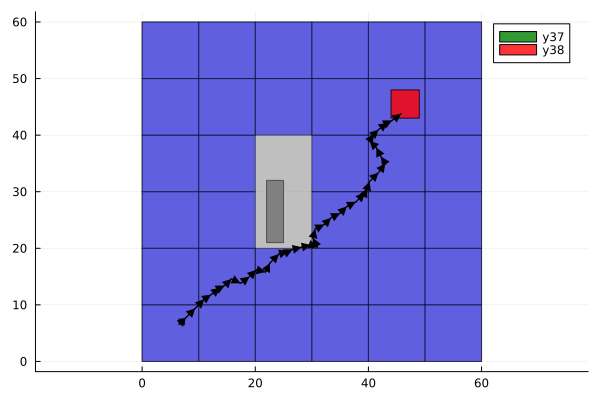

In [7]:
fig1 = plot(; aspect_ratio = :equal);

#We display the concrete domain
plot!(concrete_system.X; color = :grey, opacity = 0.5, label = "");

#We display the abstract domain
plot!(abstract_system.symmodel.Xdom; efficient = false, color = :blue, opacity = 0.5);

#We display the concrete specifications
plot!(concrete_problem.initial_set; color = :green, opacity = 0.8);
plot!(concrete_problem.target_set; dims = [1, 2], color = :red, opacity = 0.8);

#We display the concrete trajectory
plot!(x_traj; ms = 0.5)

# Display the lazy abstraction

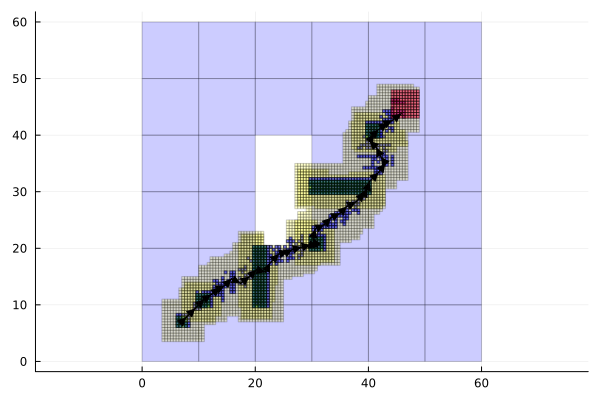

In [8]:
fig2 = plot(; aspect_ratio = :equal);

plot!(
    optimizer.hierarchical_problem;
    path = optimizer.optimizer_BB.best_sol,
    heuristic = false,
    fine = true,
    efficient = false,
)
plot!(x_traj; ms = 0.5)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*